In [48]:
import pandas as pd
import seaborn as sns
import numpy as np
import geocoder
import gmaps
import statsmodels.api as sm

import pytz

import psycopg2

from sklearn.linear_model import Ridge

import spacy

import swifter

import matplotlib.patches as mpatches

import requests


In [49]:
# Plot settings
%pylab inline

figsize(15, 9)

import matplotlib.style as style

style.use('childsafeai')

Populating the interactive namespace from numpy and matplotlib


In [50]:
from local_settings import GOOGLE_API_KEY

gmaps.configure(GOOGLE_API_KEY)

# Tests

## Processing

In [51]:
tests = requests.get("https://covidtracking.com/api/states/daily").json()
tests_df = pd.DataFrame(tests)
tests_df

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200407,AK,213.0,6700.0,NaN,NaN,23.0,NaN,NaN,NaN,...,23.0,6913,6913,6913,02,0.0,0.0,8.0,22.0,30.0
1,20200407,AL,2119.0,12797.0,NaN,NaN,271.0,NaN,NaN,NaN,...,271.0,14916,14916,14916,01,6.0,31.0,0.0,151.0,151.0
2,20200407,AR,946.0,12692.0,NaN,74.0,130.0,NaN,43.0,26.0,...,130.0,13638,13638,13638,05,0.0,-7.0,722.0,71.0,793.0
3,20200407,AS,0.0,20.0,11.0,NaN,NaN,NaN,NaN,NaN,...,NaN,31,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200407,AZ,2575.0,30800.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,33375,33375,33375,04,8.0,0.0,722.0,119.0,841.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1816,20200304,OR,3.0,29.0,18.0,NaN,NaN,NaN,NaN,NaN,...,NaN,50,32,32,41,NaN,NaN,NaN,NaN,NaN
1817,20200304,SC,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5,5,5,45,NaN,NaN,NaN,NaN,NaN
1818,20200304,TX,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,48,NaN,NaN,NaN,NaN,NaN
1819,20200304,WA,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,39,39,39,53,NaN,NaN,NaN,NaN,NaN


In [52]:
tests_df['dateChecked'] = pd.to_datetime(tests_df['dateChecked'])
tests_df['Date'] = pd.to_datetime(tests_df['dateChecked'].dt.date)

In [53]:
tests_df[['positive', 'negative', 'pending', 'death', 'total']] = tests_df[['positive', 'negative', 'pending', 'death', 'total']].astype(int, errors='ignore')

In [54]:
tests_df['completed'] = tests_df['positive'] + tests_df['negative']

In [55]:
%store tests_df

Stored 'tests_df' (DataFrame)


## Analysis

In [56]:
tests_df.groupby('Date')['completed'].sum().max()

2054462.0

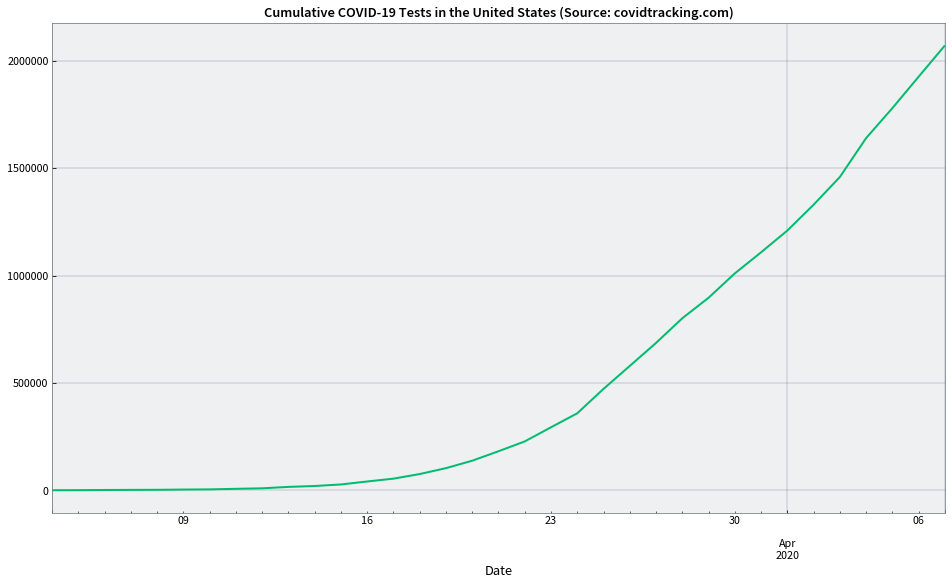

In [57]:
tests_df.groupby('Date')['total'].sum().plot(kind='line', 
                                                    title="Cumulative COVID-19 Tests in the United States (Source: covidtracking.com)")

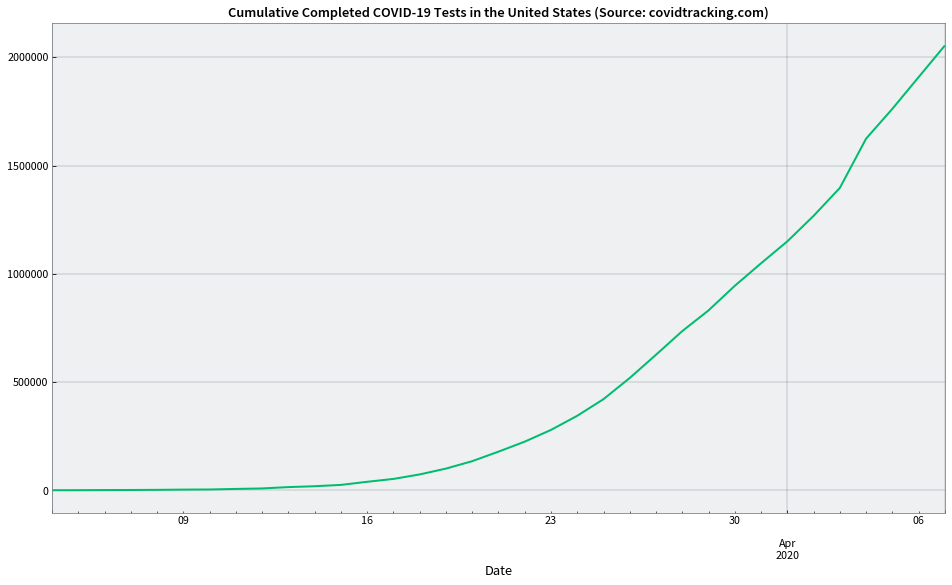

In [58]:
tests_df.groupby('Date')['completed'].sum().plot(kind='line', 
                                                    title="Cumulative Completed COVID-19 Tests in the United States (Source: covidtracking.com)")

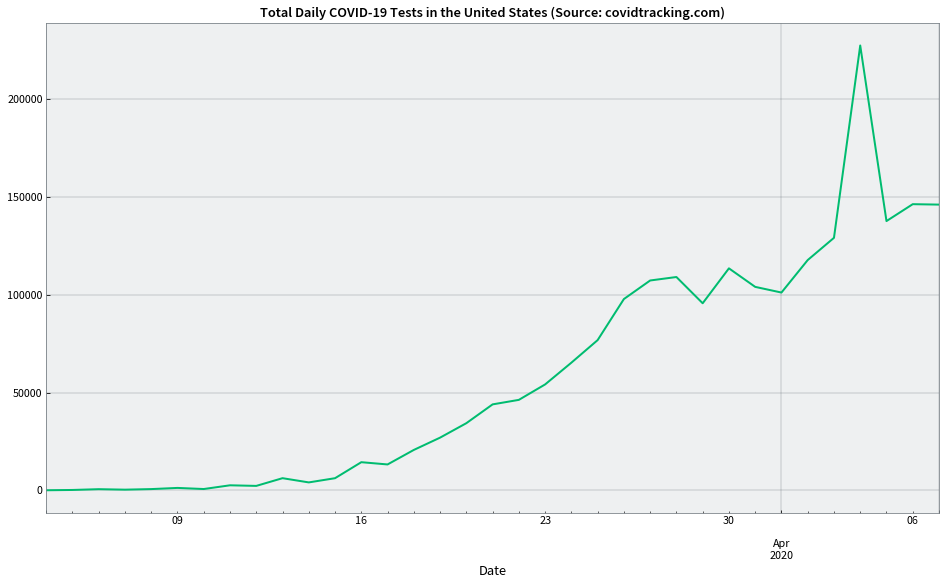

In [59]:
tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', 
                                                    title="Total Daily COVID-19 Tests in the United States (Source: covidtracking.com)")

In [60]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

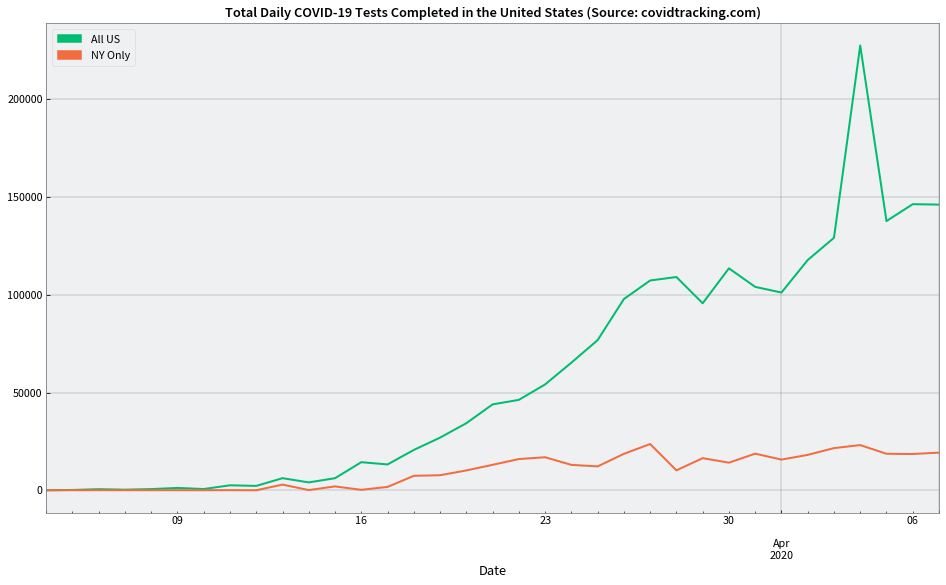

In [61]:
figsize(16, 9)
ax = tests_df.groupby('Date')['totalTestResultsIncrease'].sum().plot(kind='line', label="US",
                                                    title="Total Daily COVID-19 Tests Completed in the United States (Source: covidtracking.com)")

tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line', ax=ax)

ax.legend(handles=[mpatches.Patch(color="#00bc70", label="All US"),
                   mpatches.Patch(color="#f36c3f", label="NY Only")])

In [62]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('Date')['total'].sum().diff().mean()

118465.0

In [63]:
tests_df[(tests_df['state'] == 'NY') & (tests_df['Date'] >= '2020-03-23')].groupby('Date')['total'].sum().diff().mean()

17451.266666666666

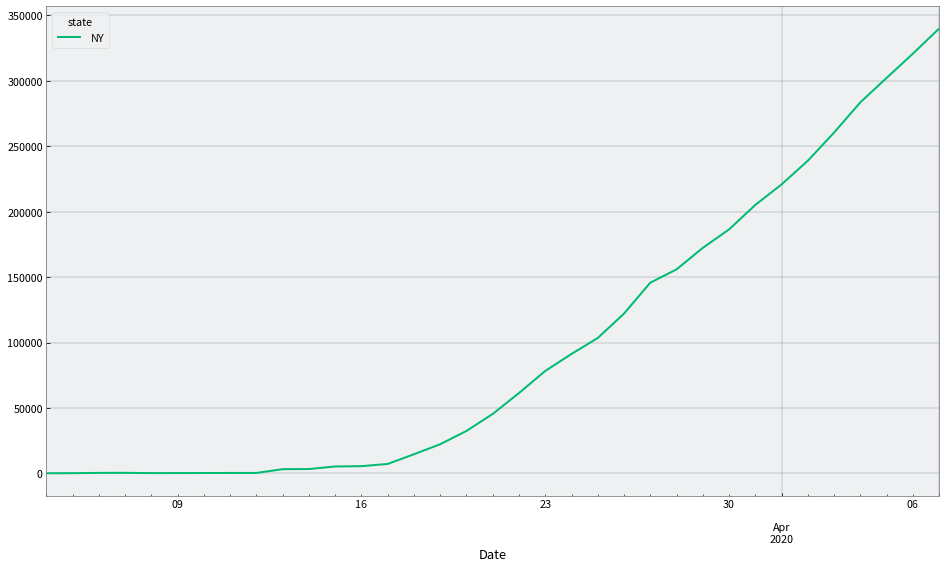

In [64]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line')

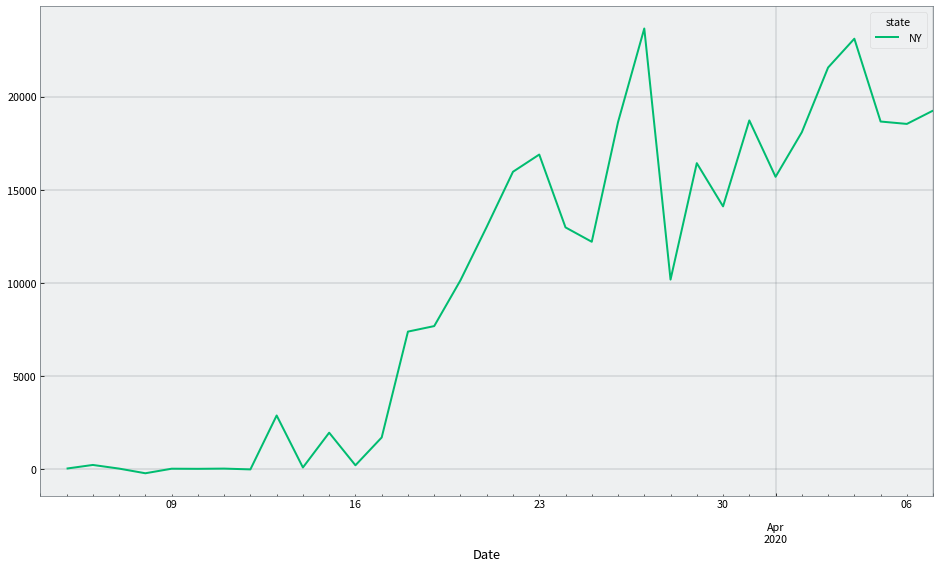

In [65]:
tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line')

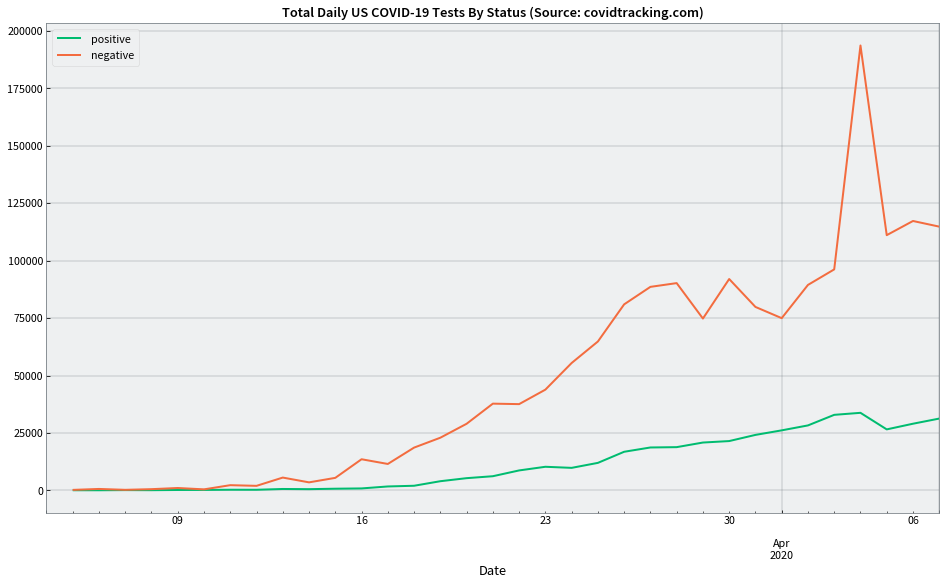

In [66]:
tests_df.groupby('Date')[['positive', 'negative']].sum().diff().plot(kind='line', 
                                                                     title="Total Daily US COVID-19 Tests By Status (Source: covidtracking.com)")

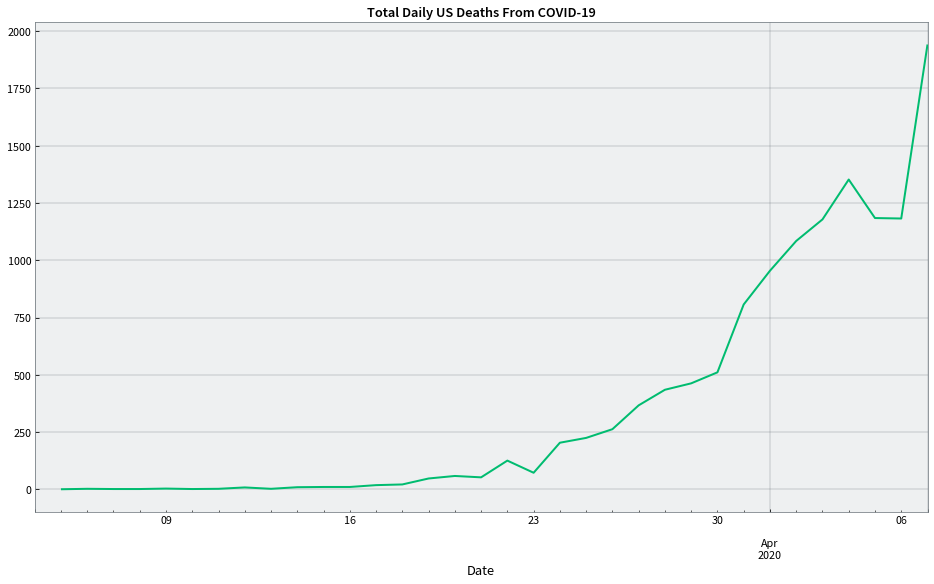

In [67]:
tests_df.groupby('Date')['death'].sum().diff().plot(kind='line',
                                                    title="Total Daily US Deaths From COVID-19")

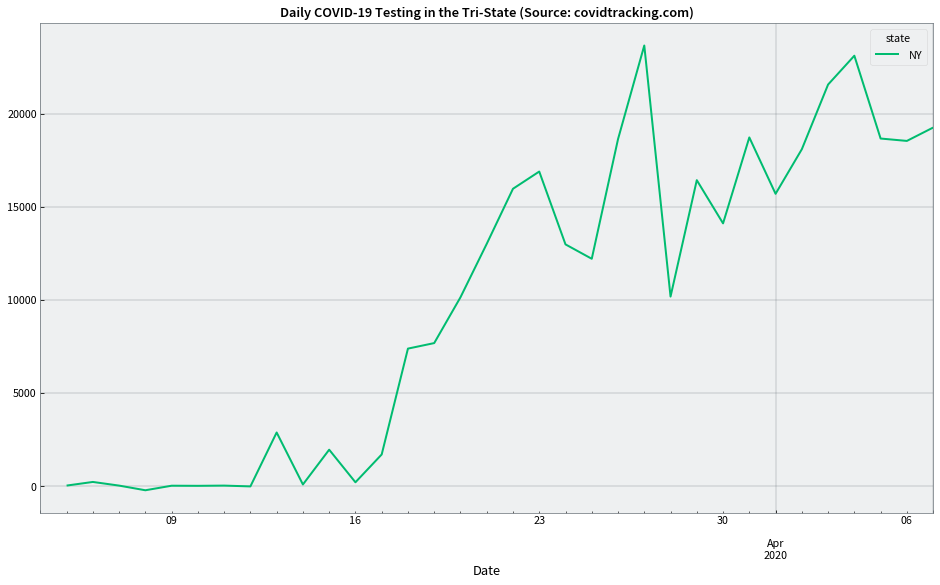

In [68]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])['total'].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

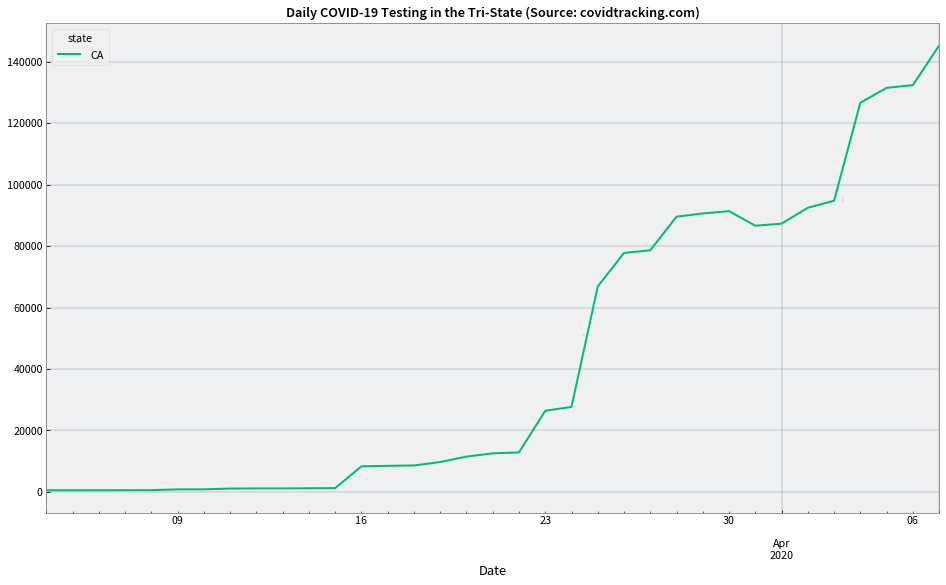

In [69]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['total'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

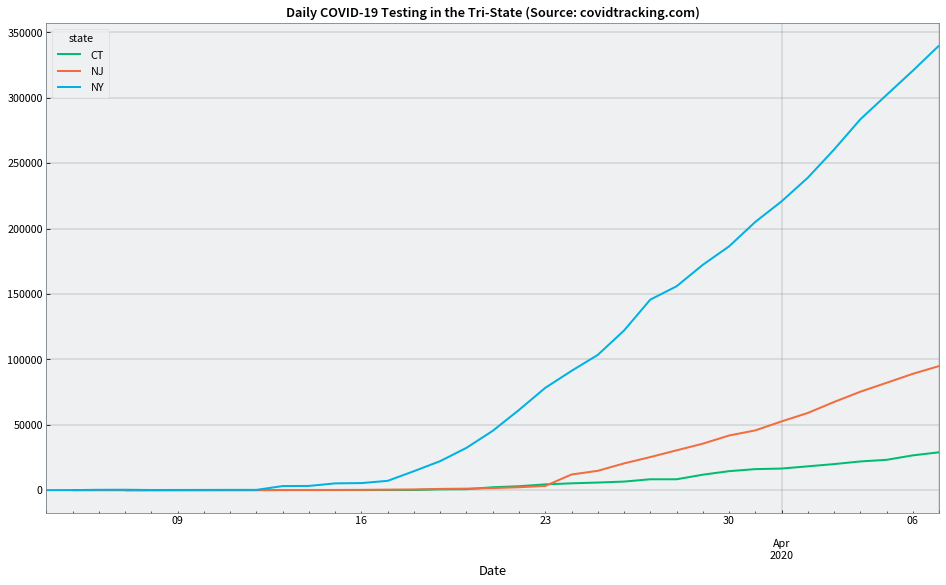

In [70]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'CT', 'NJ'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Daily COVID-19 Testing in the Tri-State (Source: covidtracking.com)")

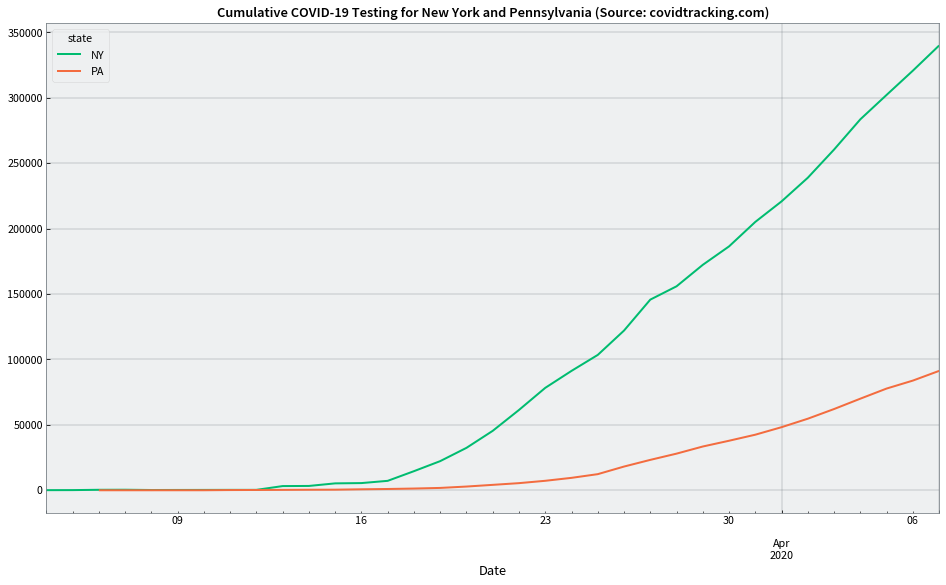

In [71]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'PA'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Pennsylvania (Source: covidtracking.com)")

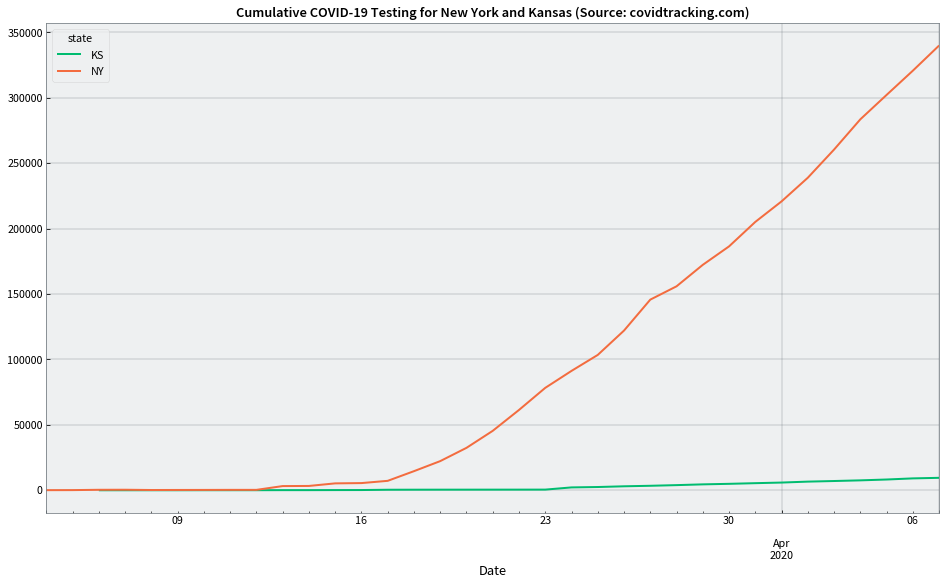

In [72]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY', 'KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York and Kansas (Source: covidtracking.com)")

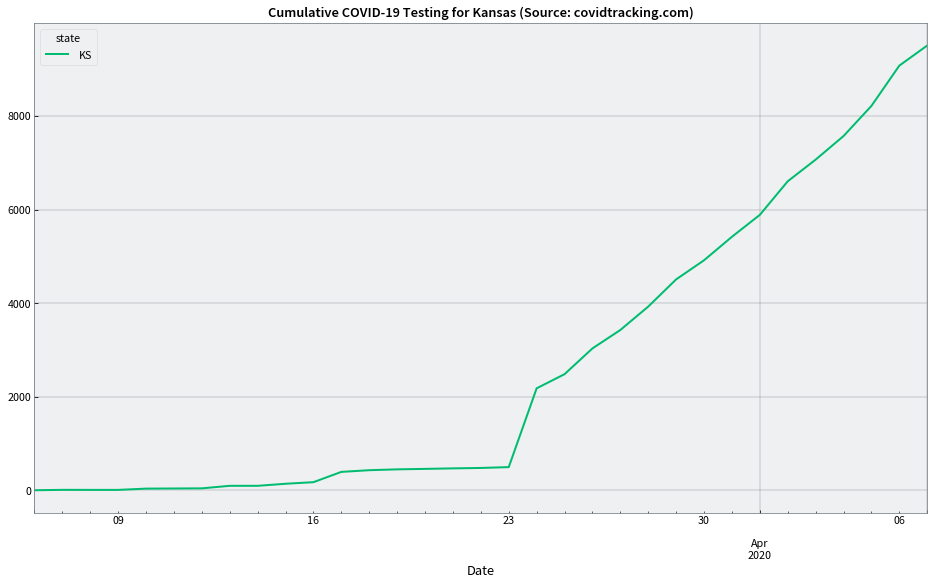

In [73]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

In [74]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

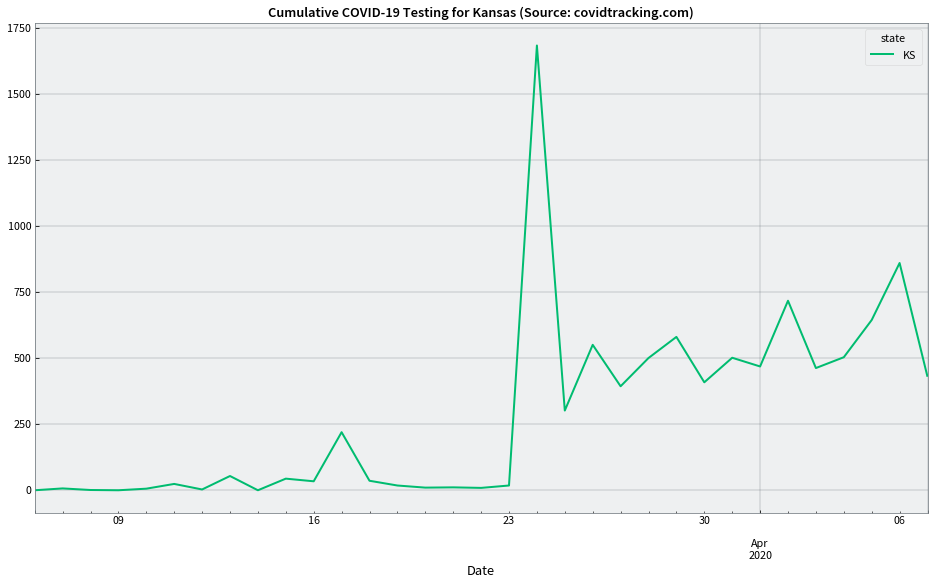

In [75]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['KS'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for Kansas (Source: covidtracking.com)")

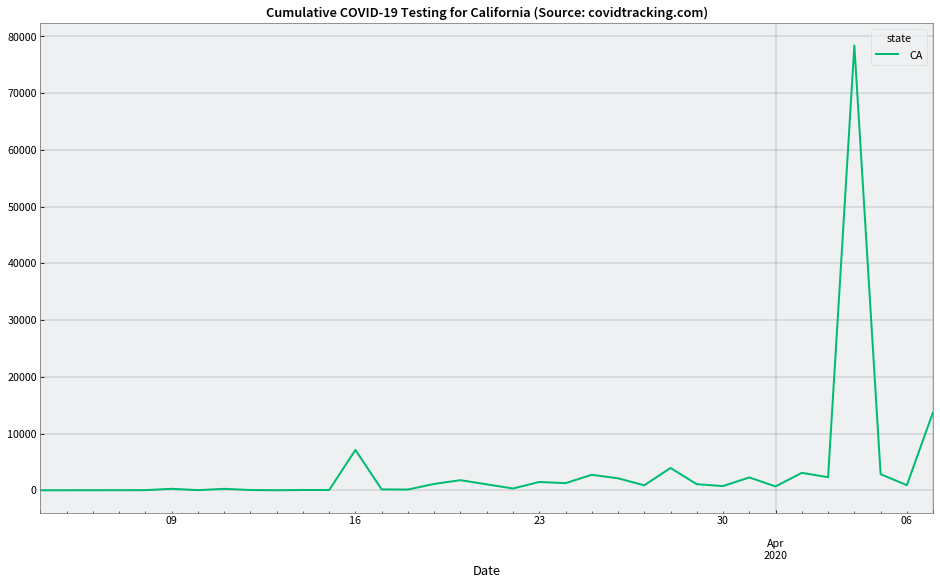

In [76]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['CA'])].groupby(['Date', 'state'])['totalTestResultsIncrease'].sum().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for California (Source: covidtracking.com)")

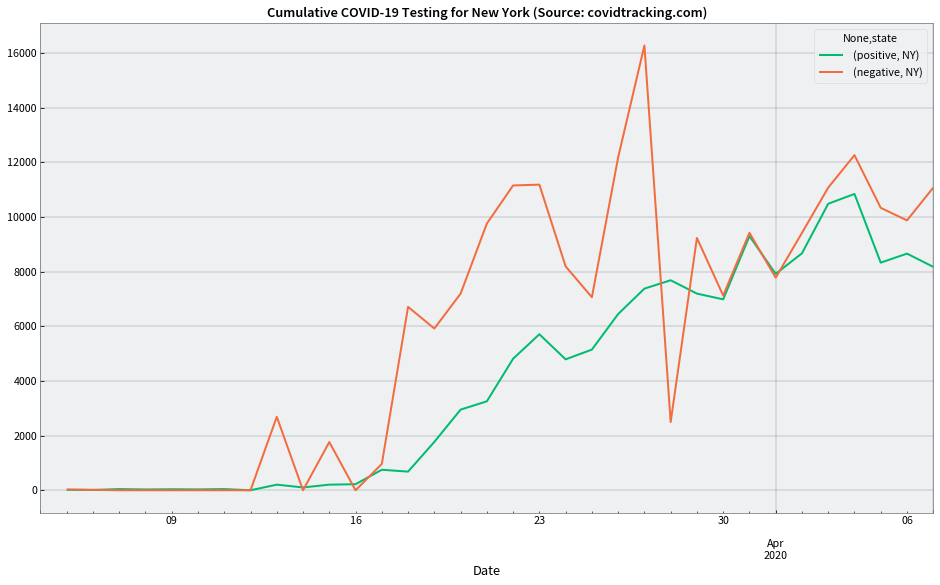

In [77]:
figsize(16, 9)
tests_df[tests_df['state'].isin(['NY'])].groupby(['Date', 'state'])[['positive', 'negative']].max().diff().unstack('state').plot(kind='line',
                                                                                                                     title="Cumulative COVID-19 Testing for New York (Source: covidtracking.com)")

In [78]:
tests_df.dtypes

date                                      int64
state                                    object
positive                                float64
negative                                float64
pending                                 float64
hospitalizedCurrently                   float64
hospitalizedCumulative                  float64
inIcuCurrently                          float64
inIcuCumulative                         float64
onVentilatorCurrently                   float64
onVentilatorCumulative                  float64
recovered                               float64
hash                                     object
dateChecked                 datetime64[ns, UTC]
death                                   float64
hospitalized                            float64
total                                     int64
totalTestResults                          int64
posNeg                                    int64
fips                                     object
deathIncrease                           

In [79]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100)

Date
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-07         NaN
2020-03-08         NaN
2020-03-09         NaN
2020-03-10         NaN
2020-03-11         NaN
2020-03-12         NaN
2020-03-13         NaN
2020-03-14         NaN
2020-03-15         NaN
2020-03-16         NaN
2020-03-17         NaN
2020-03-18         NaN
2020-03-19         NaN
2020-03-20         NaN
2020-03-21    3.527962
2020-03-22    3.214931
2020-03-23    3.365735
2020-03-24    3.543333
2020-03-25    3.677075
2020-03-26    5.605058
2020-03-27    5.849622
2020-03-28    6.447600
2020-03-29    7.005686
2020-03-30    7.358367
2020-03-31    7.751016
2020-04-01    8.315828
2020-04-02    8.711318
2020-04-03    9.095655
2020-04-04    9.302203
2020-04-05    9.293370
2020-04-06    9.414577
2020-04-07    9.434567
dtype: float64

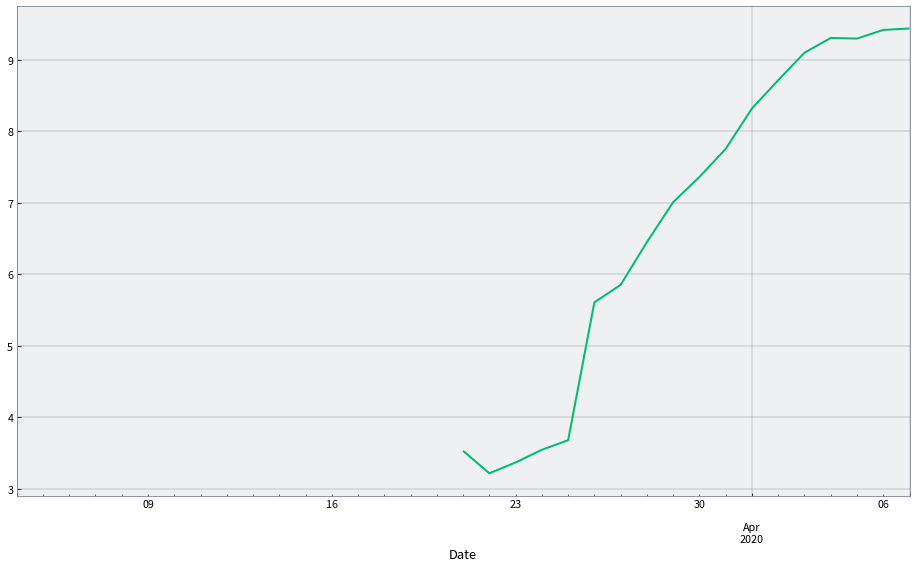

In [80]:
((tests_df[tests_df['state'] == 'NY'].groupby('Date')['hospitalized'].max() / tests_df[tests_df['state'] == 'NY'].groupby('Date')['total'].max()) * 100).plot(kind='line')

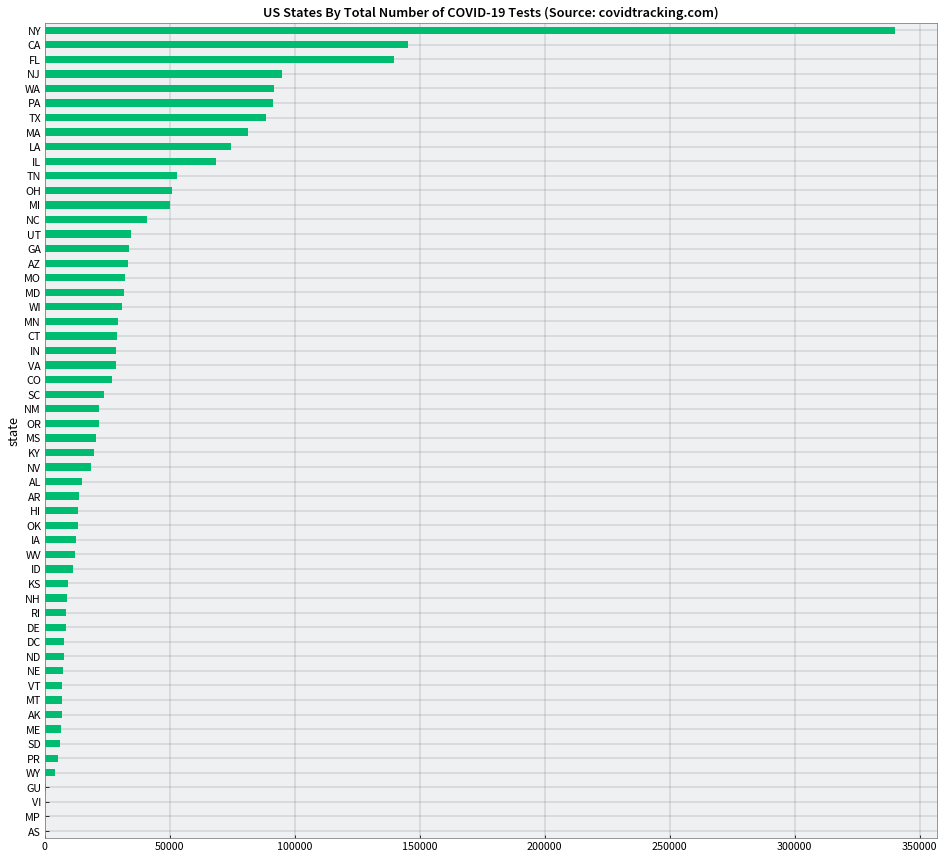

In [81]:
figsize(16,15)
tests_df.groupby('state')['total'].max().sort_values().plot(kind='barh',
                                                            title="US States By Total Number of COVID-19 Tests (Source: covidtracking.com)")

In [82]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values()

state
AS        1.2500
MP        1.4375
VI       16.1875
GU       31.0625
WY      221.4375
ME      265.8750
PR      270.8125
SD      344.1875
MT      363.0000
AK      371.5625
VT      373.1875
ND      400.9375
DC      423.0000
NE      428.3750
NH      467.5625
RI      475.8125
DE      529.0000
KS      564.5625
ID      626.8125
IA      713.3125
WV      728.8750
OK      784.8125
AR      797.6250
HI      826.9375
AL      832.1250
NV     1000.0625
NM     1065.3750
KY     1149.0000
OR     1173.5000
MS     1201.6250
SC     1376.1875
CO     1395.3125
WI     1529.6875
MN     1536.2500
VA     1581.7500
CT     1621.0000
IN     1704.3750
GA     1855.8125
UT     1934.8750
MD     1955.5625
MO     1969.3750
AZ     2058.8125
NC     2165.2500
MI     2951.7500
TN     3068.5625
OH     3146.6875
IL     3775.7500
WA     4040.8750
LA     4447.3125
MA     4702.4375
TX     4993.3125
PA     5364.6875
NJ     5795.8125
CA     7399.3125
FL     8083.8750
NY    17416.0625
Name: totalTestResultsIncrease, dtype: flo

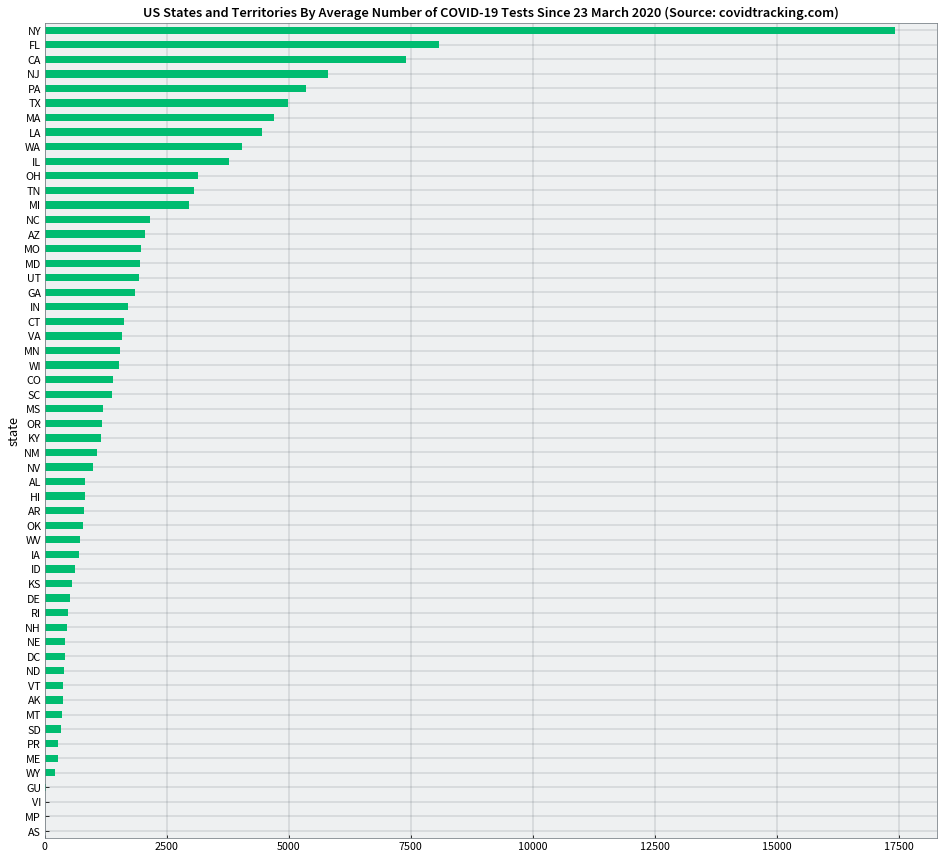

In [83]:
tests_df[tests_df['Date'] >= '2020-03-23'].groupby('state')['totalTestResultsIncrease'].mean().sort_values().plot(kind='barh',
                                                                                                                  title="US States and Territories By Average Number of COVID-19 Tests Since 23 March 2020 (Source: covidtracking.com)")

In [84]:
tests_df.groupby('state')['positive'].max().sort_values()

state
AS         0.0
MP         8.0
VI        43.0
GU       121.0
AK       213.0
WY       216.0
ND       237.0
MT       319.0
SD       320.0
HI       387.0
WV       412.0
NE       447.0
ME       519.0
PR       573.0
VT       575.0
NM       686.0
NH       715.0
KS       900.0
DE       928.0
AR       946.0
KY      1008.0
IA      1048.0
MN      1069.0
OR      1132.0
ID      1170.0
DC      1211.0
RI      1229.0
OK      1472.0
UT      1738.0
MS      1915.0
NV      2087.0
AL      2119.0
SC      2417.0
AZ      2575.0
WI      2578.0
MO      3037.0
NC      3221.0
VA      3333.0
TN      4138.0
MD      4371.0
OH      4782.0
CO      5172.0
IN      5507.0
CT      7781.0
TX      8262.0
WA      8384.0
GA      8818.0
IL     13549.0
PA     14559.0
FL     14747.0
MA     15202.0
CA     15865.0
LA     16284.0
MI     18970.0
NJ     44416.0
NY    138863.0
Name: positive, dtype: float64

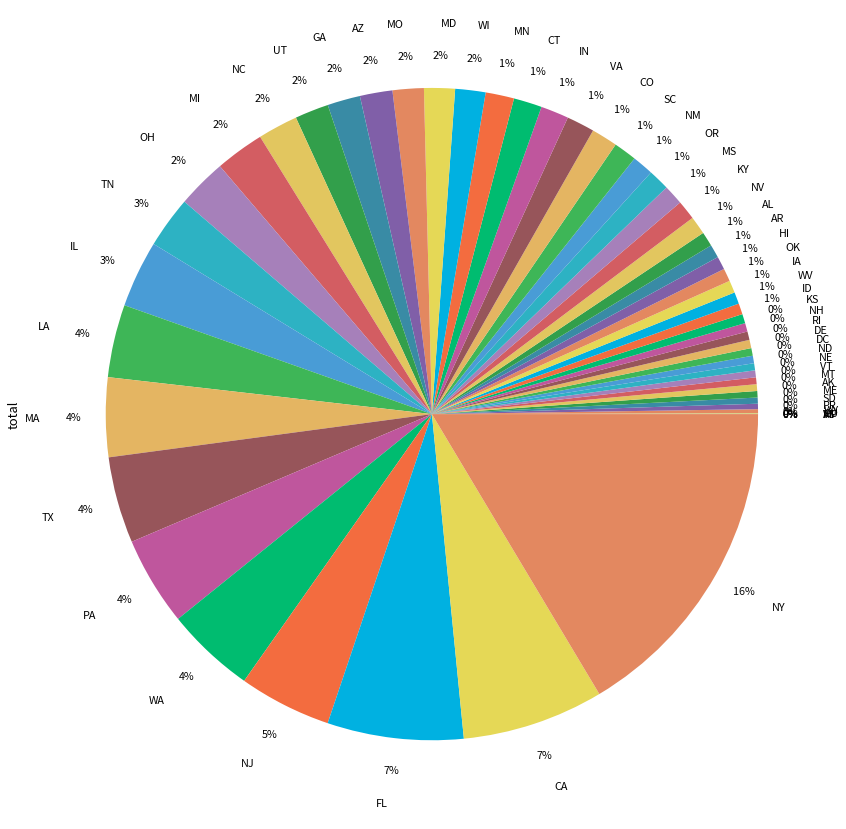

In [85]:
tests_df.groupby('state')['total'].max().sort_values().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,)

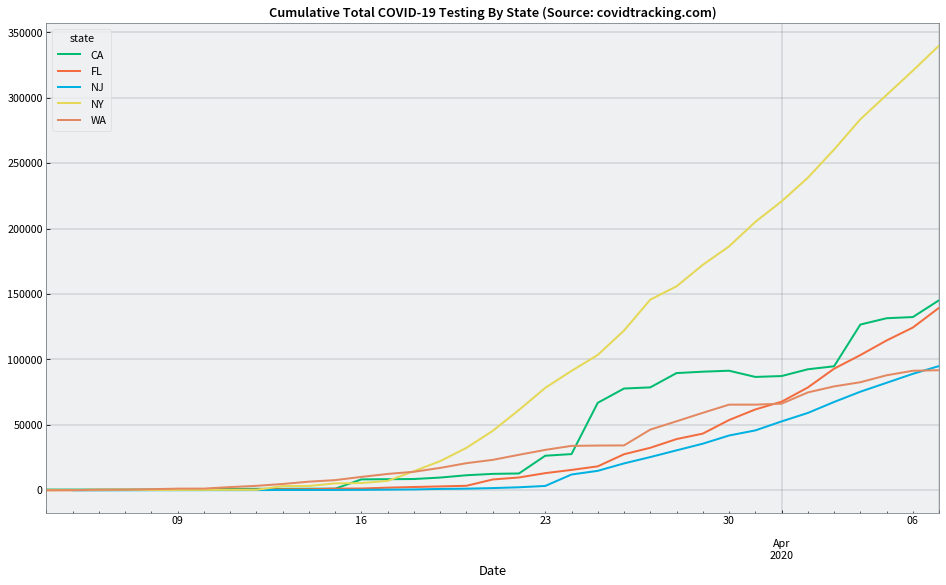

In [86]:
figsize(16, 9)
tests_df[tests_df['state'].isin(tests_df.groupby('state')['total'].max().sort_values()[-5:].index)].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                                                                                     title="Cumulative Total COVID-19 Testing By State (Source: covidtracking.com)")

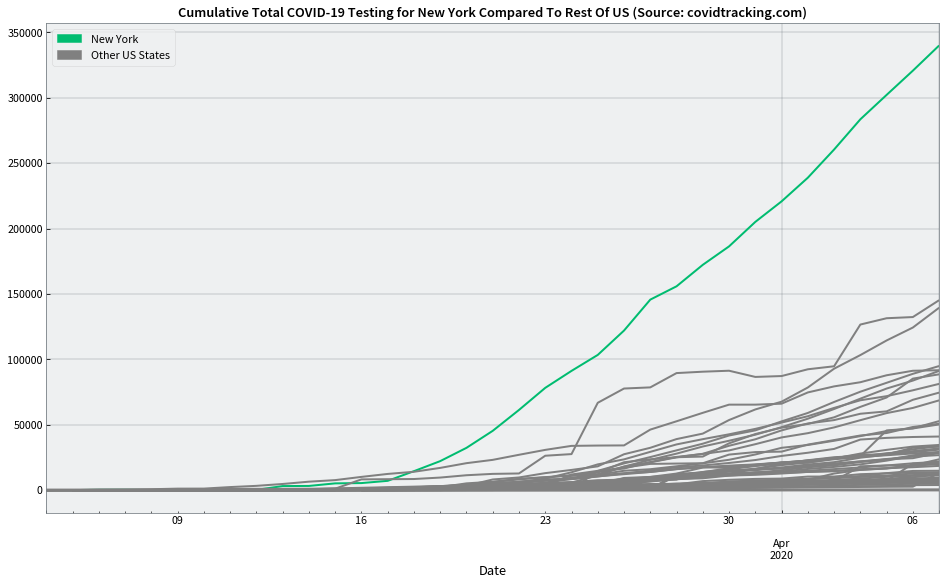

In [87]:


figsize(16, 9)
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                         title="Cumulative Total COVID-19 Testing for New York Compared To Rest Of US (Source: covidtracking.com)")

tests_df[-(tests_df['state'] == 'NY')].groupby(['Date', 'state'])['total'].max().unstack('state').plot(kind='line',
                                                                                                       color="gray",
                                                                                                       legend=False,
                                                                                                       ax=ax)

patch = mpatches.Patch(color="gray", label="Other US States")
ax.legend(handles=[mpatches.Patch(color="#00bc70", label="New York"),
                   mpatches.Patch(color="gray", label="Other US States")])

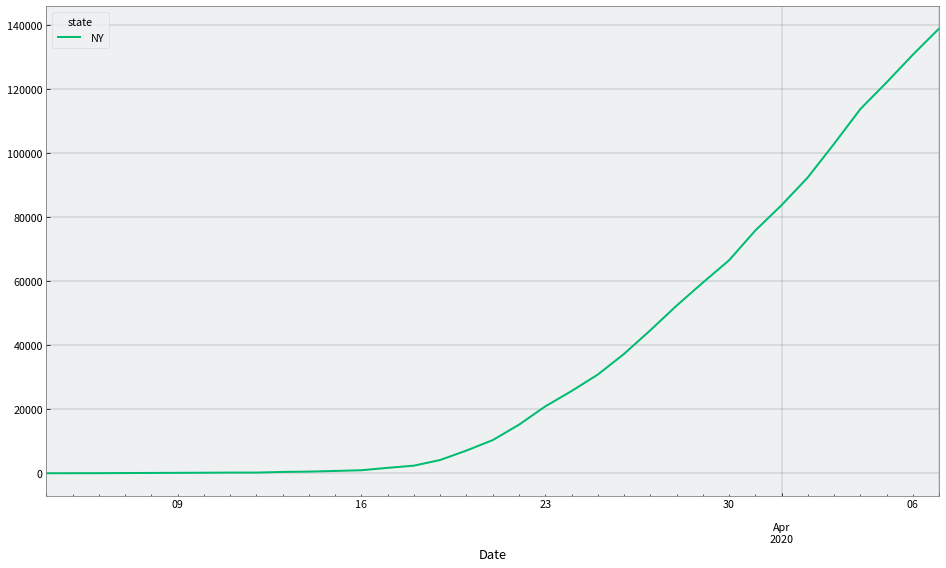

In [88]:
ax = tests_df[tests_df['state'] == 'NY'].groupby(['Date', 'state'])['positive'].max().unstack('state').plot(kind='line', color="#00bc70", label="Positive COVID-19 Tests")

In [89]:
ny_state_hospitalization['Cumulative Hospitalized'] = 

SyntaxError: invalid syntax (<ipython-input-89-cc48b835a970>, line 1)

In [ ]:
tests_df['New York?'] = tests_df['state'].str.contains('NY')

In [ ]:
ax = tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2, legend=False,
                                                       title="Distribution of COVID-19 Testing - New York vs. Rest of the United States (Source: covidtracking.com)",
                                                       labels=['Rest of US', 'New York'])

In [ ]:
tests_df[tests_df['Date'] == '2020-03-22'].groupby('New York?')['total'].sum()

In [ ]:
tests_df.groupby(['Date', 'New York?'])['total'].sum().unstack('New York?').diff()